In [40]:
from bioformers.datasets.ArrowDataset import ArrowDataset
from bioformers.datasets import dataset_utils
from bioformers.utilize.Bert import BertSeqClassification
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import os
import numpy
import warnings 

from transformers import BertModel, BertTokenizer, BertForSequenceClassification, pipeline
import re

from datasets import load_dataset
from datasets import Dataset
from datasets import load_from_disk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
from sklearn import metrics

from matplotlib import pyplot as plt

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["MKL_THREADING_LAYER"] = "GNU"
os.environ["TOKENIZERS_PARALLELISM"] = "true"

#########################
gpu_idx = 2

data_folder = "encoded_labels_datasets"
encoded_label_filename = "puffinCaller_encoded_labels_dataset_withFunctional_specific.csv"

model_folder = "puffinCaller"
model_filename = "puffinCaller_withFunctional_saved_model_maxepch8.pt"


###
encoded_csv = f"/mnt/storage/grid/home/eric/hmm2bert/data_prep/{data_folder}/{encoded_label_filename}"
model_path = f"/mnt/storage/grid/home/eric/hmm2bert/models/{model_folder}/{model_filename}" #single gpu saved model
###

#########################

In [21]:
# load csv to huggingface dataset AND pandas dataframe
dataset = load_dataset('csv', data_files=encoded_csv)
df = pd.read_csv(encoded_csv)
dataset1 = dataset['train']

Using custom data configuration default-d10c8a1cd93da70e
Reusing dataset csv (/home/eric/.cache/huggingface/datasets/csv/default-d10c8a1cd93da70e/0.0.0/2a88c45fed596f9421a2e7f74ab1a3cd012ef75210a5dc1950e8d60ca8d9c66c)


In [22]:
#split the dataset into train and test, this produces a list with the row positions
num_rows_list = list(range(len(dataset1)))
strat_train, strat_test = train_test_split(num_rows_list, stratify=dataset1['labels'], random_state=420)

In [23]:
#take row positions and use .iloc to select the specific row positions for test dataset
strat_test_dataset = Dataset.from_pandas(df.iloc[strat_test])

print("length: " + str(len(strat_test_dataset)))

length: 46750


In [ ]:
#load fine tuned model and set it to eval mode to freeze layers

model = torch.load(model_path) #single gpu trained model saved

#bsc = BertSeqClassification(pretrained_dir="Rostlab/prot_bert", use_adafactor=True, num_labels=33)

model.eval()
print("Model is frozen")
print(type(model))

In [5]:
#define tokenizer and pipeline for loaded in model (why do i need .bert after my model??)

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
meatpipe = pipeline(task="sentiment-analysis", model=model.bert, tokenizer=tokenizer, device=gpu_idx) #single gpu


In [24]:
#use .map to create new dataset containing our strat_test_dataset along with predicted labels and confidence value
#to understand more look at example at bottom of page

ds_with_embeddings = strat_test_dataset.map(lambda x: 
    {
        'y_pred': int(meatpipe(x['sequences'])[0]['label'].split('_')[1]),
        'confidence': meatpipe(x['sequences'])[0]['score']
    }
)

In [25]:
metrics.accuracy_score(ds_with_embeddings['labels'], ds_with_embeddings['y_pred'])

0.7324491978609625

In [26]:
metrics.balanced_accuracy_score(ds_with_embeddings['labels'], ds_with_embeddings['y_pred'])

0.5853364097925622

In [33]:
matrix = metrics.confusion_matrix(ds_with_embeddings['labels'], ds_with_embeddings['y_pred'])

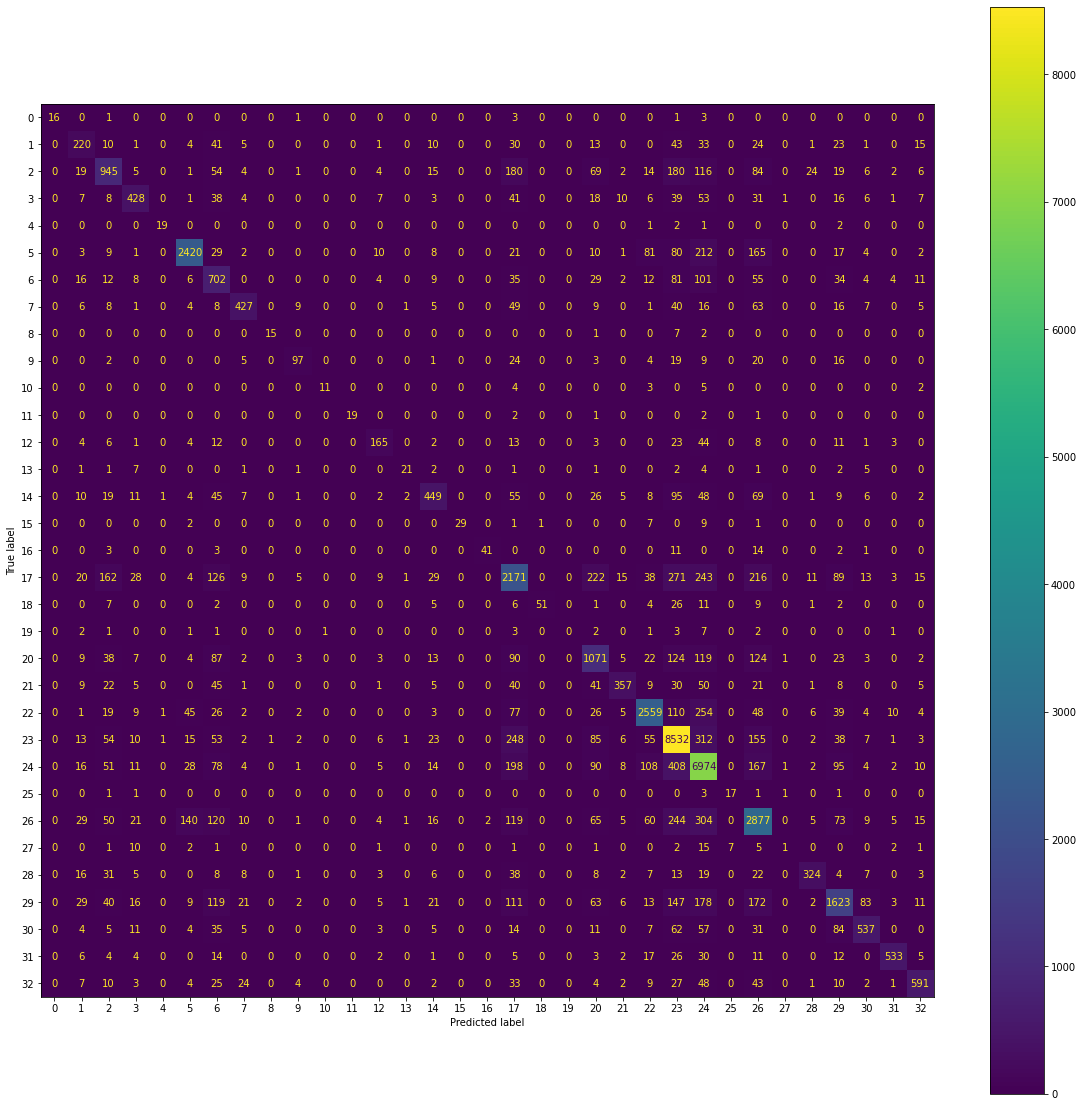

In [49]:
fig, ax = plt.subplots(figsize=(20, 20))
display = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix)
print(display.plot(ax=ax, values_format="d"))

# ========Classification Report===========

In [ ]:
matrixdict = {'y_true': ds_with_embeddings['labels'], 'y_pred': ds_with_embeddings['y_pred']}

In [ ]:
df1 = pd.DataFrame(matrixdict)

In [ ]:
#df1.to_csv("/mnt/storage/grid/home/eric/hmm2bert/model_eval/puffinCaller/puffinCaller_unbalanced_confusion_matrix.csv")

In [ ]:
df = pd.read_csv("/mnt/storage/grid/home/eric/hmm2bert/data_prep/labelled_datasets/puffin_dat_labelled_dataset.csv")
le = preprocessing.LabelEncoder()
le.fit(df['labels'])
t = list(le.classes_)
n = 0
tempdict = []
for i in t:
    tempdict = tempdict + [str(i)]

print(tempdict)

In [ ]:
t = list(le.classes_)
n = 0
label_index = []
for i in t:
    label_index = label_index + [n]
    n += 1
print(label_index)

In [ ]:
report = metrics.classification_report(ds_with_embeddings['labels'], ds_with_embeddings['y_pred'], labels = label_index, target_names = tempdict, output_dict = True)#, output_dict = True
print(report)

In [ ]:
df = pd.DataFrame(report)
df = df.transpose()

In [ ]:
df.head()
df.to_csv("/mnt/storage/grid/home/eric/hmm2bert/model_eval/puffin_dat/puffin_dat_classification_report.csv")

In [ ]:
df.head()

# ========Mis-Prediction===========

In [ ]:
df = pd.read_csv("/mnt/storage/grid/home/eric/hmm2bert/data_prep/labelled_datasets/puffin_dat_labelled_dataset.csv")
le = preprocessing.LabelEncoder()
le.fit(df['labels'])
t = list(le.classes_)
n = 0
tempdict = []
for i in t:
    tempdict = tempdict + [str(i)]

print(tempdict)

In [ ]:
df_matrix = pd.DataFrame(matrix)
label_num = 11

counter = 0
label_list = []
for i in df_matrix.loc[label_num]:
    if i > 0:
        label_list = label_list + [counter]
    counter += 1

print("Total samples: " + str(df_matrix.loc[label_num].sum()))
print("============================")
print("Predicted labels for label " + str(label_num) + f" ({tempdict[label_num]}):")
print("======")
print(df_matrix.loc[label_num][df_matrix.loc[label_num] > 0])
print("=============")
for i in label_list:
    print(str(i) + ". " + tempdict[i])

# =======Understanding the code=======

In [15]:
#create a new dataset with .map funcion on strat_test_dataset with lambda function that runs through each row creating a dict with keys 'y_pred' and 'confidence'
#y_pred value function: when passing the sequences column through the model pipeline (to tokenize and then evaluate), the result generated is a list of dicts where each dict contains the keys
#'label' and 'score', the value of key 'label' is the model predicted label while the value of key 'score' is the model's confidence that the predicted label is right
#y_pred: the first dict (specified by the [0] after meatpipe(x['sequences'])) produced by the sequence passed into the pipeline (there will only be 1 dict produced at a time because of how .map works)
#fromt he first dict, select the value corresponding to the key 'label' and split the value into a list by underscore and select the second value of the list produced by the split (this is from [1] after the split and
#is because the prediction is stored as a string e.g. 'LABEL_0', and needs to be split to only get the number prediction without any words) and then convert that number value selected from the list which is
#currently a string type to a integer type
#the second key 'confidence' contains ta value calculated by passing in the sequences through the pipeline and taking the first dict outputted (specified by the [0] after the pipeline) and selecting the value housed
#in the key 'score' 

ds_with_embeddings = strat_test_dataset.map(lambda x: 
    {
        'y_pred': int(meatpipe(x['sequences'])[0]['label'].split('_')[1]),
        'confidence': meatpipe(x['sequences'])[0]['score']
    }
)

In [16]:
temp = meatpipe(strat_test_dataset['sequences'])
print(temp[:5])

[{'label': 'LABEL_13', 'score': 0.6869746446609497}, {'label': 'LABEL_17', 'score': 0.4010418653488159}, {'label': 'LABEL_15', 'score': 0.6546763777732849}, {'label': 'LABEL_15', 'score': 0.8642116785049438}, {'label': 'LABEL_15', 'score': 0.7615765929222107}]


In [65]:
#this will take the 6th dict (because starts at 0) stored in the list produced by pipeline
#['label'] specifies to take the value stored in the key 'label' in the 6th dict in the list and to split that value (which is a string type) by underscore symbol (creating a list of the split strings)
#and then to take the second value of the split strings list (which is the predicted label)

temp[5]['label'].split('_')[1]

'0'

In [ ]:
#we can see the dict of predicted labels and confidence are added to the strat_test_dataset

ds_with_embeddings[:6]